# Module

In [1]:
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
%%time

import random
import pandas as pd
import numpy as np
import polars as pl
from tqdm import tqdm
import category_encoders as ce
from IPython.display import clear_output

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import *
from sklearn.metrics import *

import optuna
import lightgbm as lgb
from lightgbm import early_stopping  
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

import warnings

warnings.filterwarnings('ignore')

CPU times: user 788 ms, sys: 631 ms, total: 1.42 s
Wall time: 1.09 s


In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [4]:
np.random.seed(2024)
random.seed(2024)

# Func

In [32]:
%%time

def load_data():    
    train = pd.read_csv('data/train.csv')
    test = pd.read_csv('data/test.csv')    
    all_df = pd.concat([train, test], sort=False).reset_index(drop=True)
    return train, test, all_df

def skewed(df, all_df):
    # pt = PowerTransformer(method='yeo-johnson')
    # pt.fit(df[['Annual Income']])
    # all_df['transformed_Annual_Income'] = pt.transform(all_df[['Annual Income']])
    all_df['log_Annual_Income'] = np.log1p(all_df['Annual Income'])
    return all_df
    
def date(df):
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month_name'] = df['Policy Start Date'].dt.month_name()
    df['Day_of_week'] = df['Policy Start Date'].dt.day_name()
    df['Week'] = df['Policy Start Date'].dt.isocalendar().week
    df['Year_sin'] = np.sin(2 * np.pi * df['Year'])
    df['Year_cos'] = np.cos(2 * np.pi * df['Year'])
    min_year = df['Year'].min()
    max_year = df['Year'].max()
    df['Year_sin'] = np.sin(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Year_cos'] = np.cos(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    df['Group']=(df['Year']-2020)*48+df['Month']*4+df['Day']//7    
    df.drop('Policy Start Date', axis=1, inplace=True)
    return df

def get_nan_cols(df):
    nan_cols = ['Marital Status', 'Customer Feedback', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']
    for col in nan_cols:
        col_name = col + '_NA'
        df[col_name] = df[col].isnull().astype(int)
    return df

def get_encoding(df):
    def encode_ordinal(df):
        educ = {"High School":0, "Bachelor's":1, "Master's":2, "PhD":3}
        policy = {'Basic':0, 'Comprehensive':1, 'Premium':2}
        exerc = {'Rarely':0, 'Daily':1, 'Weekly':2, 'Monthly': 3}
        feedback = {'Poor':0, 'Average':1, 'Good':2, "Unknown": 0}

        df['Education Level'] = df['Education Level'].map(educ)
        df['Policy Type'] = df['Policy Type'].map(policy)
        df['Exercise Frequency'] = df['Exercise Frequency'].map(exerc)
        df['Customer Feedback'] = df['Customer Feedback'].map(feedback)
        df['Gender'] = df['Gender'].map({'Male':0, 'Female':1})
        df['Smoking Status'] = df['Smoking Status'].map({'Yes':1, 'No':0})
        return df

    def one_hot_dummies(df, categorical):
        oh = pd.get_dummies(df[categorical])
        df = df.drop(categorical, axis=1)
        return pd.concat([df, oh], axis=1)
        return df

    df = encode_ordinal(df)

    categorical_features = df.select_dtypes(include='object').columns
    df = one_hot_dummies(df, categorical_features)
    return df

def add_new_features(df):
    df['Income to Dependents Ratio'] = df['Annual Income'] / (df['Number of Dependents'].fillna(0) + 1)
    df['Income_per_Dependent'] = df['Annual Income'] / (df['Number of Dependents'] + 1)
    df['CreditScore_InsuranceDuration'] = df['Credit Score'] * df['Insurance Duration']
    df['Health_Risk_Score'] = df['Smoking Status'].apply(lambda x: 1 if x == 'Smoker' else 0) + \
                                df['Exercise Frequency'].apply(lambda x: 1 if x == 'Low' else (0.5 if x == 'Medium' else 0)) + \
                                (100 - df['Health Score']) / 20
    df['Credit_Health_Score'] = df['Credit Score'] * df['Health Score']
    df['Health_Age_Interaction'] = df['Health Score'] * df['Age']

    df['contract length'] = pd.cut(
        df["Insurance Duration"].fillna(99),  
        bins=[-float('inf'), 1, 3, float('inf')],  
        labels=[0, 1, 2]  
    ).astype(int)

    df['Claims_Bins'] = pd.cut(
        df["Previous Claims"].fillna(-1),  
        bins=[-float('inf'), -0.1, 2, 4, float('inf')],  
        labels=[0, 1, 2, 3]  
    ).astype('category')

    # df["Annual_Income_Health_Score_Ratio"] = df["Health Score"] / df["Annual Income"]
    # df["Annual_Income_Age_Ratio"] = df["Annual Income"] / df["Age"]
    # df["Credit_Age"] = df["Credit Score"] / df["Age"]
    # df["Vehicle_Age_Insurance_Duration"] = df["Vehicle Age"] / df["Insurance Duration"]
    return df

def prep():
    train, test, all_df = load_data()

    all_df = skewed(train, all_df)
    all_df = date(all_df)
    all_df = get_nan_cols(all_df)
    all_df = get_encoding(all_df)
    all_df = add_new_features(all_df)

    del all_df['Annual Income']
    
    train = all_df[~all_df['Premium Amount'].isnull()]
    test = all_df[all_df['Premium Amount'].isnull()]
    train.drop('id', axis=1, inplace=True)
    test.drop(['id', 'Premium Amount'], axis=1, inplace=True)
    return train, test, all_df

train, test, all_df = prep()

CPU times: user 8.41 s, sys: 1.88 s, total: 10.3 s
Wall time: 10.8 s


In [33]:
train.head()

,Age,Gender,Number of Dependents,Education Level,Health Score,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Premium Amount,log_Annual_Income,Year,Day,Month,Week,Year_sin,Year_cos,Month_sin,Month_cos,Day_sin,Day_cos,...,Month_name_December,Month_name_February,Month_name_January,Month_name_July,Month_name_June,Month_name_March,Month_name_May,Month_name_November,Month_name_October,Month_name_September,Day_of_week_Friday,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Income to Dependents Ratio,Income_per_Dependent,CreditScore_InsuranceDuration,Health_Risk_Score,Credit_Health_Score,Health_Age_Interaction,contract length,Claims_Bins
0,19.0,1,1.0,1,22.598761,2,2.0,17.0,372.0,5.0,0.0,0,2,2869.0,9.215328,2023,23,12,51,-9.510565e-01,0.309017,-2.449294e-16,1.000000e+00,-0.998717,-0.050649,...,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,5024.5,5024.5,1860.0,3.870062,8406.738970,429.376453,2,1
1,39.0,1,3.0,2,15.569731,1,1.0,12.0,694.0,2.0,1.0,1,3,1483.0,10.363409,2023,12,6,24,-9.510565e-01,0.309017,1.224647e-16,-1.000000e+00,0.651372,-0.758758,...,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,7919.5,7919.5,1388.0,4.221513,10805.393307,607.219509,1,1
2,23.0,0,3.0,0,47.177549,2,1.0,14.0,NaN,3.0,2.0,1,2,567.0,10.150465,2023,30,9,39,-9.510565e-01,0.309017,-1.000000e+00,-1.836970e-16,-0.201299,0.979530,...,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,6400.5,6400.5,NaN,2.641123,NaN,1085.083634,1,1
3,21.0,0,2.0,1,10.938144,0,1.0,0.0,367.0,1.0,0.0,1,1,765.0,11.862568,2024,12,6,24,-2.449294e-16,1.000000,1.224647e-16,-1.000000e+00,0.651372,-0.758758,...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,47285.0,47285.0,367.0,4.453093,4014.298906,229.701027,0,1
4,21.0,0,1.0,1,20.376094,2,0.0,8.0,598.0,4.0,0.0,1,2,2022.0,10.587897,2021,1,12,48,5.877853e-01,-0.809017,-2.449294e-16,1.000000e+00,0.201299,0.979530,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,19825.5,19825.5,2392.0,3.981195,12184.903989,427.897966,2,1


In [34]:
train.shape, test.shape

((1200000, 72), (800000, 71))

# AbdML

In [8]:
import os
import sys

sys.path.append(os.path.abspath("../AbdML"))

from main import AbdBase

## LGBM

In [35]:
SEED = 2024
n_splits = 10

base = AbdBase(train_data=train, test_data=test, target_column='Premium Amount', gpu=False,
                 problem_type="regression", metric="rmsle", seed=SEED,
                 n_splits=n_splits, early_stop=True, num_classes=0, fold_type='RKF')

*** AbdBase ['V_1.3'] ***

 *** Available Settings *** 

Available Models: LGBM, CAT, XGB, Voting, TABNET
Available Metrics: roc_auc, accuracy, f1, precision, recall, rmse, wmae, rmsle, mae, r2, mse
Available Problem Types: classification, regression
Available Fold Types: SKF, KF, GKF, GSKF, RKF

 *** Configuration *** 

Problem Type Selected: REGRESSION
Metric Selected: RMSLE
Fold Type Selected: RKF
Calculate Train Probabilities: False
Calculate Test Probabilities: False
Early Stopping: True
GPU: False


In [ ]:
# %%time

# param_space = {
#     'estimators': 300,
#     'boosting_type': 'gbdt',
#     'num_leaves': (10, 300),                        
#     'learning_rate': (1e-4, 1e-1),                  
#     'feature_fraction': (0.6, 1.0),                 
#     'bagging_fraction': (0.6, 1.0),                 
#     'bagging_freq': (5, 12),                        
#     'min_data_in_leaf': (10, 100),                  
#     'max_depth': (-1, 12),                          
#     'lambda_l1': (1e-4, 10.0),                      
#     'lambda_l2': (1e-4, 10.0),                      
#     'min_gain_to_split': (0.001, 0.1),
#     'n_jobs': -1
# }

# lgb_study = base.RUN_OPTUNA(
#     MODEL_NAME="LGBM",
#     PARAMS=param_space,
#     DIRECTION='minimize',
#     TRIALS=5,
#     ENABLE_PRUNER=True,              # Early termination of ineffective attempts
#     PRUNER_PARAMS={'n_startup_trials': 3, 'n_warmup_steps': 3, 'interval_steps': 3},
#     y_log=True
# )

# lgb_study.best_params

In [36]:
%%time

# Params = lgb_study.best_params
# Params['estimators'] = 1000

Params = {
 'estimators': 500,
 'boosting_type': 'gbdt',
 'num_leaves': 118,
 'learning_rate': 0.07114476009343425,
 'feature_fraction': 0.8720536237417198,
 'bagging_fraction': 0.8146346649119967,
 'bagging_freq': 6,
 'min_data_in_leaf': 24,
 'max_depth': -1,
 'lambda_l1': 2.1423021757741068,
 'lambda_l2': 0.10129197956845731,
 'min_gain_to_split': 0.02607024758370768,
 'n_jobs': -1
}

results_lgb = base.Train_ML(Params,'LGBM', e_stop=100, y_log=True)

Training Folds: 100%|██████████| 10/10 [03:40<00:00, 22.04s/it]

Overall Train RMSLE: 1.0374
Overall OOF RMSLE: 1.0459 
CPU times: user 10min 9s, sys: 8.6 s, total: 10min 17s
Wall time: 3min 40s


In [38]:
results_lgb

# 1. OOF 에측결과, 2. test 예측결과, 3. 최종학습모델 4.fold별 모델 리스트, 5. OOF 스코어, 6. 학습데이터 스코어

(array([967.65204864, 751.98340455, 808.73073974, ..., 182.45084892,
        753.74016835, 315.54459549]),
 array([800.08739221, 792.7259156 , 794.42207417, ..., 799.77302241,
        817.00798271, 785.76599183]),
 LGBMRegressor(bagging_fraction=0.8146346649119967, bagging_freq=6, device='cpu',
               estimators=500, feature_fraction=0.8720536237417198,
               lambda_l1=2.1423021757741068, lambda_l2=0.10129197956845731,
               learning_rate=0.07114476009343425, min_data_in_leaf=24,
               min_gain_to_split=0.02607024758370768, n_jobs=-1, num_leaves=118,
               random_state=2024, verbose=-1),
 [LGBMRegressor(bagging_fraction=0.8146346649119967, bagging_freq=6, device='cpu',
                estimators=500, feature_fraction=0.8720536237417198,
                lambda_l1=2.1423021757741068, lambda_l2=0.10129197956845731,
                learning_rate=0.07114476009343425, min_data_in_leaf=24,
                min_gain_to_split=0.02607024758370768, n_job

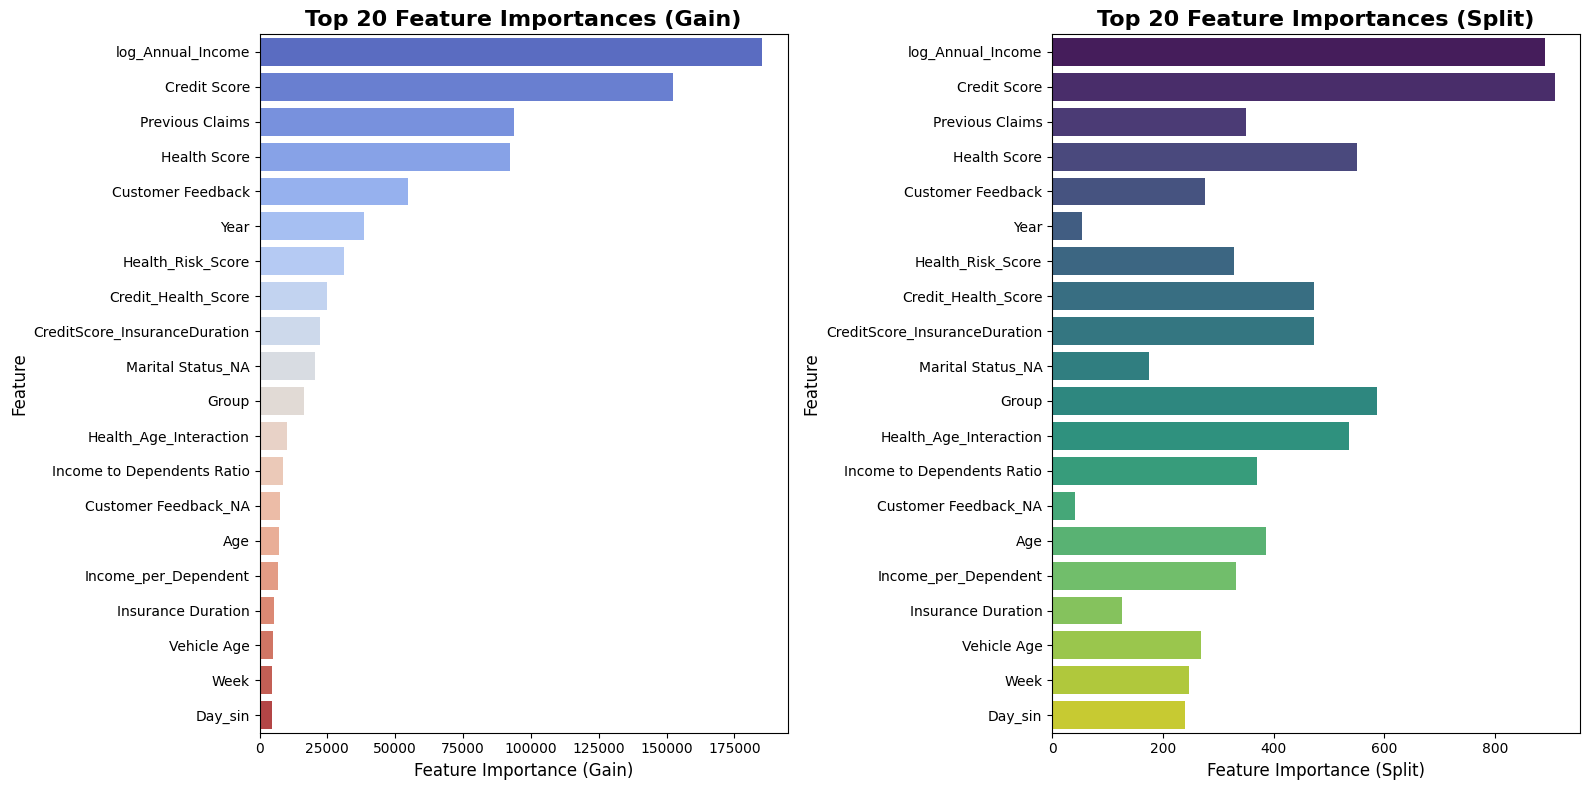

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

model_lgb = results_lgb[2].booster_

importances_gain = model_lgb.feature_importance(importance_type='gain')
importances_split = model_lgb.feature_importance(importance_type='split')
features = test.columns

sorted_indices = importances_gain.argsort()[::-1]

importance_df = pd.DataFrame({
    'Feature': [features[i] for i in sorted_indices],
    'Gain': importances_gain[sorted_indices],
    'Split': importances_split[sorted_indices]
})

top_features = importance_df.head(20)


fig, axes = plt.subplots(1, 2, figsize=(16, 8)) 
plt.subplots_adjust(wspace=0.4) 

sns.barplot(data=top_features, x='Gain', y='Feature', ax=axes[0], palette="coolwarm")
axes[0].set_title("Top 20 Feature Importances (Gain)", fontsize=16, fontweight='bold')
axes[0].set_xlabel("Feature Importance (Gain)", fontsize=12)
axes[0].set_ylabel("Feature", fontsize=12)

sns.barplot(data=top_features, x='Split', y='Feature', ax=axes[1], palette="viridis")
axes[1].set_title("Top 20 Feature Importances (Split)", fontsize=16, fontweight='bold')
axes[1].set_xlabel("Feature Importance (Split)", fontsize=12)
axes[1].set_ylabel("Feature", fontsize=12)

plt.tight_layout()
plt.show()

## CatBoost

In [32]:
%%time

param_space = {
    "iterations":300,
    "learning_rate": (1e-4, 1e-1),
    "depth": (3, 12),
    "l2_leaf_reg": (1e-4, 10.0),
    "bagging_temperature": (1e-3, 1.0),
    "random_strength": (1e-3, 10.0),
    "border_count": (32, 255),
    "colsample_bylevel": (0.6, 1.0),
}

cat_study = base.RUN_OPTUNA(
    MODEL_NAME="CAT",
    PARAMS=param_space,
    DIRECTION='minimize',
    TRIALS=5,
    ENABLE_PRUNER=True,              # Early termination of ineffective attempts
    PRUNER_PARAMS={'n_startup_trials': 3, 'n_warmup_steps': 3, 'interval_steps': 3},
    y_log=True
)

cat_study.best_params

[I 2024-12-27 05:31:08,488] A new study created in memory with name: no-name-e5a97b98-2a66-46c7-924d-bb5e0f409fbf
Training Folds: 100%|██████████| 10/10 [09:58<00:00, 59.86s/it]
[I 2024-12-27 05:41:07,157] Trial 0 finished with value: 1.0703 and parameters: {'learning_rate': 0.0013292918943162175, 'depth': 12, 'l2_leaf_reg': 0.4570563099801455, 'bagging_temperature': 0.06251373574521749, 'random_strength': 0.004207988669606638, 'border_count': 66, 'colsample_bylevel': 0.6180690932801379}. Best is trial 0 with value: 1.0703.
Training Folds: 100%|██████████| 10/10 [05:16<00:00, 31.66s/it]
[I 2024-12-27 05:46:23,778] Trial 1 finished with value: 1.0523 and parameters: {'learning_rate': 0.0396760507705299, 'depth': 9, 'l2_leaf_reg': 0.3470266988650412, 'bagging_temperature': 0.00115279871282324, 'random_strength': 7.579479953348009, 'border_count': 218, 'colsample_bylevel': 0.6687417180293094}. Best is trial 1 with value: 1.0523.
Training Folds: 100%|██████████| 10/10 [03:02<00:00, 18.29s/

CPU times: user 1h 20min 15s, sys: 1min 32s, total: 1h 21min 47s
Wall time: 24min 18s


{'learning_rate': 0.0396760507705299,
 'depth': 9,
 'l2_leaf_reg': 0.3470266988650412,
 'bagging_temperature': 0.00115279871282324,
 'random_strength': 7.579479953348009,
 'border_count': 218,
 'colsample_bylevel': 0.6687417180293094}

In [34]:
%%time

Params = cat_study.best_params
Params['iterations'] = 1000

results_cat = base.Train_ML(Params,'CAT', e_stop=200, y_log=True)

Training Folds: 100%|██████████| 10/10 [17:39<00:00, 105.95s/it]

Overall Train RMSLE: 1.0331
Overall OOF RMSLE: 1.0470 
CPU times: user 56min 24s, sys: 2min 26s, total: 58min 50s
Wall time: 17min 39s


In [40]:
results_cat

(array([948.54578956, 750.34836391, 804.01920793, ..., 183.65217835,
        737.65949109, 290.38160347]),
 array([791.53121895, 777.52688274, 762.57050624, ..., 819.85472178,
        799.67671511, 763.55549787]),
 '1.0470',
 '1.0331')

# Ensemble

In [35]:
def objective(trial):
    global results_lgb, results_cat, train
    
    w1 = trial.suggest_float('w1', 0.0, 1.0)
    w2 = 1.0 - w1
    
    ensemble_vote = (w1 * results_lgb[0]) + (w2 * results_cat[0])
    rmsle = root_mean_squared_log_error(train['Premium Amount'], ensemble_vote)
    
    return rmsle

study_vote = optuna.create_study(direction='minimize')
study_vote.optimize(objective, n_trials=100)

print(f"Best Weights: {study_vote.best_params}")
print(f"Best RMSLE: {study_vote.best_value:.4f}")

[I 2024-12-27 06:13:50,513] A new study created in memory with name: no-name-f9b1792d-9712-40d4-b200-e6d54bff001d
[I 2024-12-27 06:13:50,530] Trial 0 finished with value: 1.0457973797810431 and parameters: {'w1': 0.5738049154531849}. Best is trial 0 with value: 1.0457973797810431.
[I 2024-12-27 06:13:50,543] Trial 1 finished with value: 1.0462403546306638 and parameters: {'w1': 0.2812729924615003}. Best is trial 0 with value: 1.0457973797810431.
[I 2024-12-27 06:13:50,555] Trial 2 finished with value: 1.0457072389813378 and parameters: {'w1': 0.7136440114053322}. Best is trial 2 with value: 1.0457072389813378.
[I 2024-12-27 06:13:50,567] Trial 3 finished with value: 1.0465784933914017 and parameters: {'w1': 0.14006825934310196}. Best is trial 2 with value: 1.0457072389813378.
[I 2024-12-27 06:13:50,580] Trial 4 finished with value: 1.045693008461401 and parameters: {'w1': 0.7744819362300569}. Best is trial 4 with value: 1.045693008461401.
[I 2024-12-27 06:13:50,591] Trial 5 finished wi

Best Weights: {'w1': 0.7993802602017795}
Best RMSLE: 1.0457


In [38]:
best_weights = study_vote.best_params
best_weights['w2'] = 1 - best_weights['w1']

In [39]:
ensemble_vote = (best_weights['w1'] * results_lgb[0]) + (best_weights['w2'] * results_cat[0])

rmse = root_mean_squared_log_error(train['Premium Amount'], ensemble_vote)
mae = mean_absolute_error(train['Premium Amount'], ensemble_vote)
r2 = r2_score(train['Premium Amount'], ensemble_vote)

print(f"\nPerformance Metrics:\n{'-'*25}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Performance Metrics:
-------------------------
RMSE: 1.0457
MAE: 621.1012
R²: -0.1383


# Submission

In [41]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.head()

,id,Premium Amount
0,1200000,1102.545
1,1200001,1102.545
2,1200002,1102.545
3,1200003,1102.545
4,1200004,1102.545


In [42]:
preds = (best_weights['w1'] * results_lgb[1]) + (best_weights['w2'] * results_cat[1])
submission['Premium Amount'] = preds
submission.head()

,id,Premium Amount
0,1200000,820.515617
1,1200001,787.700958
2,1200002,787.675737
3,1200003,803.375572
4,1200004,757.157465


In [43]:
submission.to_csv('./data/04_01_AbdML.csv', index=False)
!kaggle competitions submit -c playground-series-s4e12 -f "./data/04_01_AbdML.csv" -m "04_01_AbdML_ensemble"

100%|██████████████████████████████████████| 19.8M/19.8M [00:00<00:00, 37.4MB/s]
Successfully submitted to Regression with an Insurance Dataset

> **Public Score Comparison**

- **Baseline Model:**
  - **Public Score:** 1.04849  
  - **Rank:** 498 / 1653 (30.12%)  

- **Second Model (Feature Engineering + PowerTransformer):**
  - **Public Score:** 1.04506  
  - **Rank:** 334 / 1693 (19.72%)

- **NaN (NA col + No imputer):**
  - **Public Score:** 1.04496  
  - **Rank:** 378 / 1895 (19.94%)

- **Ensemble(lgbm + xgb + catboost):**
  - **Public Score:** 1.04475  
  - **Rank:** 346 / 1906 (18.15%)

- **AbdML(RKF) + Ensemble(lgbm + catboost):**
  - **Public Score:** 1.04473  
  - **Rank:** 357 / 1951 (18.29%)